# Loads audio file paths and labels them as "yes" (scream) or "no" (non-scream) and prints the total count and distribution of labels.

# Load Audio Files

In [1]:
import os

scream_dir = r"D:\Ashraf\NCI\Semester 2\Research In Computing\Dataset\Screaming"
non_scream_dir = r"D:\Ashraf\NCI\Semester 2\Research In Computing\Dataset\NotScreaming"

file_paths = []
labels = []

for file_name in os.listdir(scream_dir):
    file_paths.append(os.path.join(scream_dir, file_name))
    labels.append("yes")

for file_name in os.listdir(non_scream_dir):
    file_paths.append(os.path.join(non_scream_dir, file_name))
    labels.append("no")

print(f"Loaded {len(file_paths)} audio files.")
print(f"Number of files: {len(file_paths)}")
print(f"Labels count: {len(labels)}")
print(f"Scream files labeled 'yes': {labels.count('yes')}")
print(f"Non-scream files labeled 'no': {labels.count('no')}")

Loaded 3493 audio files.
Number of files: 3493
Labels count: 3493
Scream files labeled 'yes': 862
Non-scream files labeled 'no': 2631


# Visualizes the distribution of scream and non-scream files using a bar chart to understand class imbalance.

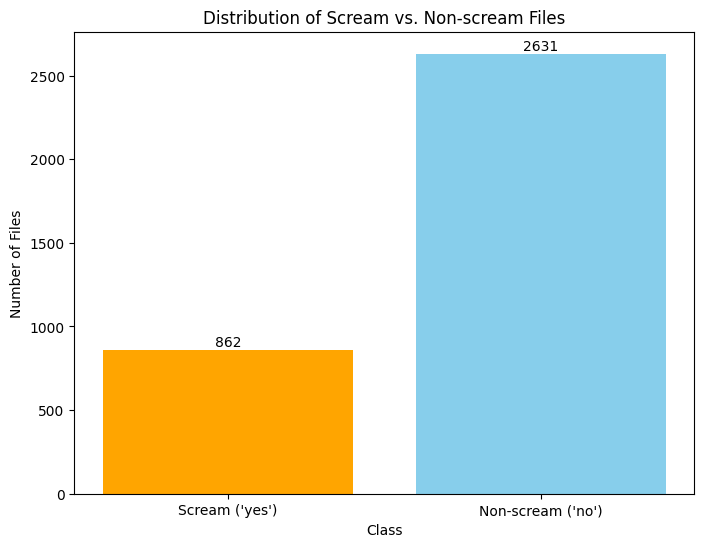

In [2]:
import matplotlib.pyplot as plt

label_counts = [labels.count("yes"), labels.count("no")]
label_names = ["Scream ('yes')", "Non-scream ('no')"]

plt.figure(figsize=(8, 6))
bars = plt.bar(label_names, label_counts, color=['orange', 'skyblue'])
plt.xlabel("Class")
plt.ylabel("Number of Files")
plt.title("Distribution of Scream vs. Non-scream Files")

plt.bar_label(bars, label_type='edge')

plt.show()

# Sampling

# Uses upsampling to balance the scream and non-scream samples, ensuring equal representation in the dataset.

In [3]:
from sklearn.utils import resample
import numpy as np

yes_indices = [i for i, label in enumerate(labels) if label == 'yes']
no_indices = [i for i, label in enumerate(labels) if label == 'no']

yes_upsampled = resample(
    yes_indices,
    replace=True,
    n_samples=len(no_indices),
    random_state=42
)

balanced_indices = yes_upsampled + no_indices
np.random.shuffle(balanced_indices)

# Verifies the balanced dataset by displaying the new counts for both labels.

In [4]:
file_paths_balanced = [file_paths[i] for i in balanced_indices]
labels_balanced = [labels[i] for i in balanced_indices]

print(f"Balanced dataset size: {len(labels_balanced)}")
print(f"Number of 'yes': {labels_balanced.count('yes')}")
print(f"Number of 'no': {labels_balanced.count('no')}")

Balanced dataset size: 5262
Number of 'yes': 2631
Number of 'no': 2631


# Visualizes the distribution of scream and non-scream files using a bar chart after upsampling

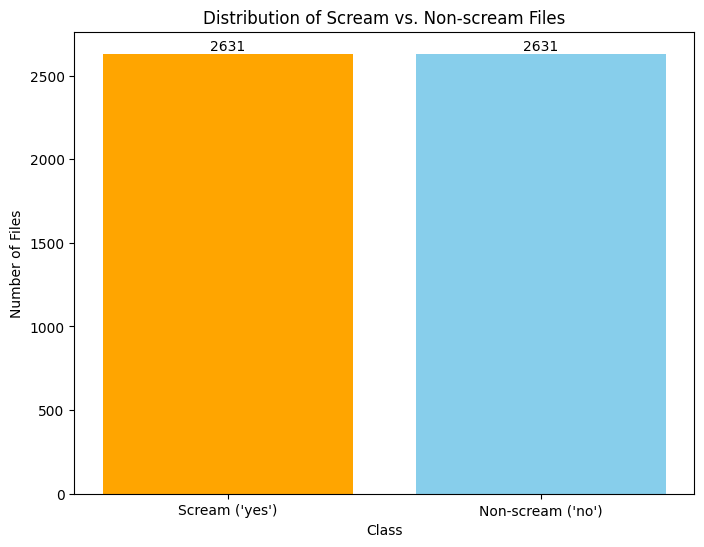

In [5]:
label_counts = [labels_balanced.count("yes"), labels_balanced.count("no")]
label_names = ["Scream ('yes')", "Non-scream ('no')"]

plt.figure(figsize=(8, 6))
bars = plt.bar(label_names, label_counts, color=['orange', 'skyblue'])
plt.xlabel("Class")
plt.ylabel("Number of Files")
plt.title("Distribution of Scream vs. Non-scream Files")

plt.bar_label(bars, label_type='edge')

plt.show()

# Extract and count the sample rates of the audio files, ensuring consistency across the dataset.

In [6]:
import librosa
from collections import Counter

sample_rates = []

def get_sample_rate(file_path):
    return librosa.get_samplerate(file_path)

for file_path in file_paths_balanced:
    sample_rate = get_sample_rate(file_path)
    sample_rates.append(sample_rate)

sample_rate_counts = Counter(sample_rates)

print("Sample Rate Overview:")
for rate, count in sample_rate_counts.items():
    print(f"Sample Rate: {rate} Hz")
    print(f"Number of Files: {count}")

Sample Rate Overview:
Sample Rate: 44100 Hz
Number of Files: 5262


# Visualizes the raw audio waveforms of randomly selected scream (yes) and non-scream (no) audio samples. The purpose of this visualization is to provide an understanding of the time-domain characteristics of the audio signals, such as amplitude variations and patterns over time.

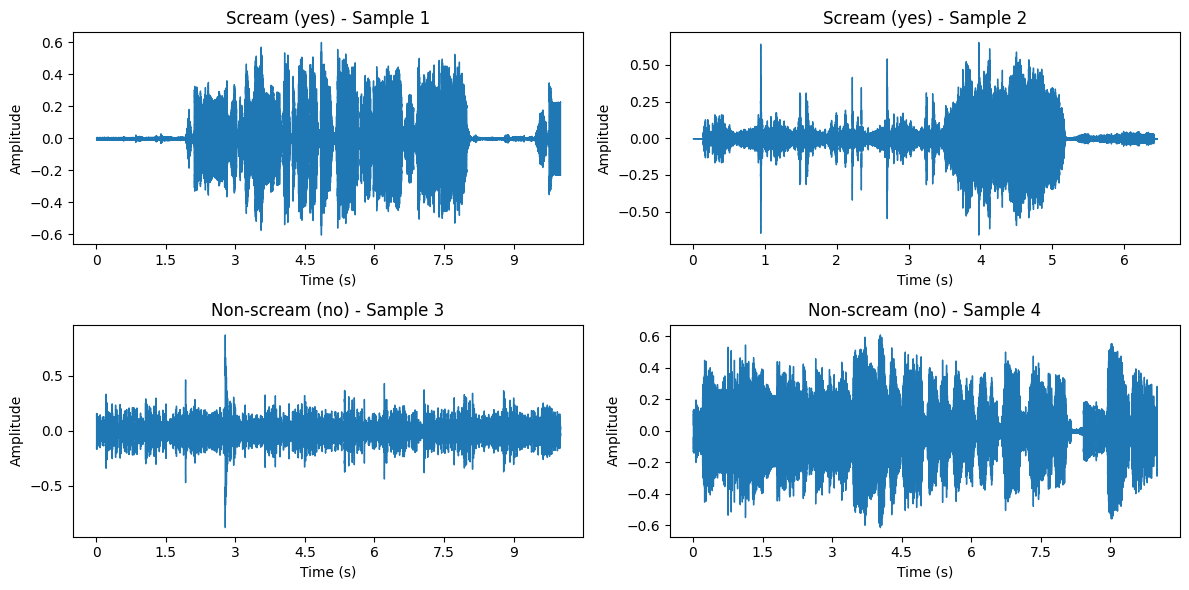

In [7]:
import random
import librosa.display
import matplotlib.pyplot as plt

def display_waveforms(file_paths_balanced, labels_balanced, num_samples=2):
    scream_files = [file for file, label in zip(file_paths_balanced, labels_balanced) if label == "yes"]
    non_scream_files = [file for file, label in zip(file_paths_balanced, labels_balanced) if label == "no"]

    scream_samples = random.sample(scream_files, num_samples)
    non_scream_samples = random.sample(non_scream_files, num_samples)

    plt.figure(figsize=(12, 6))
    for i, file_path in enumerate(scream_samples + non_scream_samples, 1):
        audio, sample_rate = librosa.load(file_path, sr=44100)
        plt.subplot(2, num_samples, i)
        librosa.display.waveshow(audio, sr=sample_rate)
        title = "Scream (yes)" if i <= num_samples else "Non-scream (no)"
        plt.title(f"{title} - Sample {i}")
        plt.xlabel("Time (s)")
        plt.ylabel("Amplitude")
    plt.tight_layout()
    plt.show()

display_waveforms(file_paths_balanced, labels_balanced, num_samples=2)

# Visualizes the spectrograms of scream and non-scream audio samples using Short-Time Fourier Transform (STFT). It allows for inspecting the frequency content of audio signals over time, which is crucial for analyzing scream patterns.

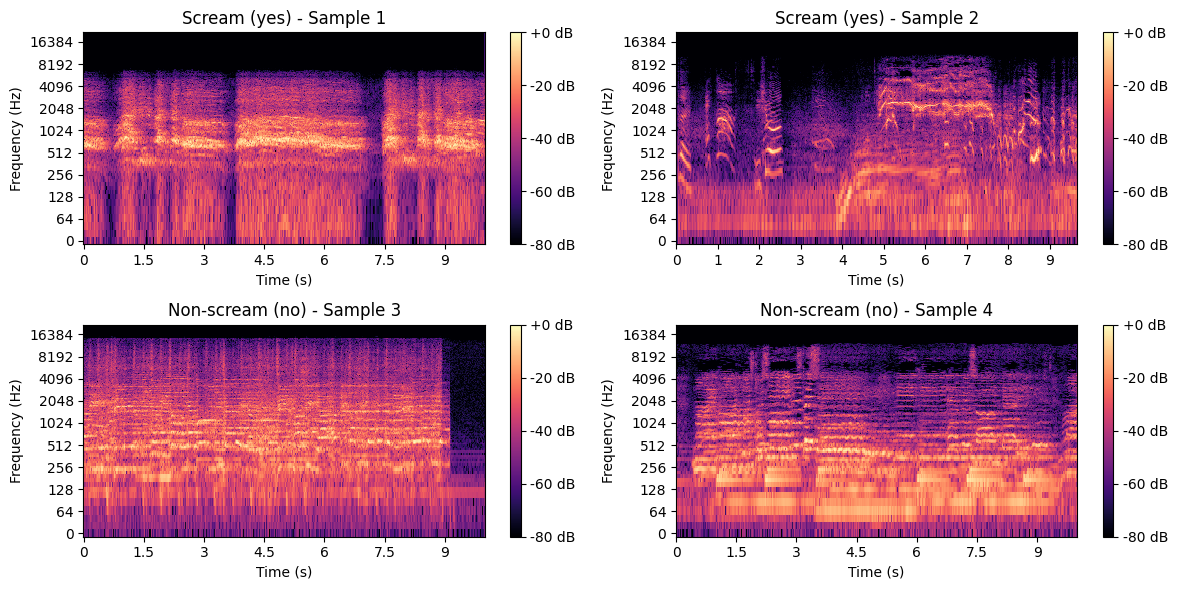

In [8]:
import librosa.display
import numpy as np

def display_stft_spectrograms(file_paths_balanced, labels_balanced, num_samples=2):
    scream_files = [file for file, label in zip(file_paths_balanced, labels_balanced) if label == "yes"]
    non_scream_files = [file for file, label in zip(file_paths_balanced, labels_balanced) if label == "no"]

    scream_samples = random.sample(scream_files, num_samples)
    non_scream_samples = random.sample(non_scream_files, num_samples)

    plt.figure(figsize=(12, 6))
    for i, file_path in enumerate(scream_samples + non_scream_samples, 1):
        audio, sample_rate = librosa.load(file_path, sr=44100)

        S = librosa.stft(audio)
        S_dB = librosa.amplitude_to_db(abs(S), ref=np.max)

        plt.subplot(2, num_samples, i)
        librosa.display.specshow(S_dB, sr=sample_rate, x_axis='time', y_axis='log')
        title = "Scream (yes)" if i <= num_samples else "Non-scream (no)"
        plt.title(f"{title} - Sample {i}")
        plt.colorbar(format='%+2.0f dB')
        plt.xlabel("Time (s)")
        plt.ylabel("Frequency (Hz)")

    plt.tight_layout()
    plt.show()

display_stft_spectrograms(file_paths_balanced, labels_balanced, num_samples=2)

# Performs data augmentation on the audio dataset to enhance model robustness and mitigate data scarcity. Augmentation generates new variations of the original audio files by applying transformations that mimic natural variations in audio signals.

In [9]:
import os
import librosa
import numpy as np
import soundfile as sf
from tqdm import tqdm

augmented_dir = r"D:\Ashraf\NCI\Semester 3\Code\augmented_data_new"
os.makedirs(augmented_dir, exist_ok=True)

def time_shift(audio, shift_max=0.2):
    shift = int(np.random.uniform(-shift_max, shift_max) * len(audio))
    return np.roll(audio, shift)

def pitch_shift(audio, sample_rate, n_steps):
    return librosa.effects.pitch_shift(audio, sr=sample_rate, n_steps=n_steps)

def speed_change(audio, speed_factor):
    return librosa.effects.time_stretch(audio, rate=speed_factor)

def add_noise(audio, noise_factor=0.005):
    noise = np.random.randn(len(audio))
    noisy_audio = audio + noise_factor * noise
    return noisy_audio / np.max(np.abs(noisy_audio))

def augment_audio(audio, sample_rate, file_name, label, augmentations=None, save_dir=augmented_dir):
    os.makedirs(save_dir, exist_ok=True)
    if augmentations is None:
        augmentations = ['time_shift', 'pitch_shift', 'speed_change', 'add_noise']

    augmented_file_paths = []
    augmented_labels = []

    for augmentation in augmentations:
        save_path = os.path.join(save_dir, f"{file_name}_{augmentation}.wav")
        
        if os.path.exists(save_path):
            # print(save_path)
            augmented_file_paths.append(save_path)
            augmented_labels.append(label)
            continue

        if augmentation == "time_shift":
            augmented = time_shift(audio)
        elif augmentation == "pitch_shift":
            n_steps = np.random.randint(-2, 3)
            augmented = pitch_shift(audio, sample_rate, n_steps)
        elif augmentation == "speed_change":
            speed_factor = np.random.uniform(0.9, 1.1)
            augmented = speed_change(audio, speed_factor)
        elif augmentation == "add_noise":
            augmented = add_noise(audio)

        sf.write(save_path, augmented, sample_rate)
        augmented_file_paths.append(save_path)
        augmented_labels.append(label)

    return augmented_file_paths, augmented_labels

file_paths_augmented = []
labels_augmented = []

for file_path, label in tqdm(zip(file_paths_balanced, labels_balanced), total=len(file_paths_balanced)):
    audio, sample_rate = librosa.load(file_path, sr=44100)
    file_name = os.path.splitext(os.path.basename(file_path))[0]
    augmented_file_paths, augmented_labels = augment_audio(audio, sample_rate, file_name, label, save_dir=augmented_dir)
    file_paths_augmented.extend(augmented_file_paths)
    labels_augmented.extend(augmented_labels)

print(f"Augmented audio files saved in: {augmented_dir}")
print(f"Total augmented files: {len(file_paths_augmented)}")


100%|██████████| 5262/5262 [00:56<00:00, 93.63it/s] 

Augmented audio files saved in: D:\Ashraf\NCI\Semester 3\Code\augmented_data_new
Total augmented files: 21048


# Save the metadata of augmented audio files into a CSV file for easy reference and future use.

In [10]:
# import pandas as pd

# augmented_data = pd.DataFrame({"file_path": file_paths_augmented, "label": labels_augmented})
# augmented_data.to_csv("augmented_data_metadata.csv", index=False)
# print("Augmented data metadata saved to augmented_data_metadata.csv")

# Check the distribution of augmented labels to ensure that the dataset remains balanced after data augmentation.

In [11]:
from collections import Counter

unique_labels = set(labels_augmented)
label_counts = Counter(labels_augmented)

print(f"Unique labels: {unique_labels}")
print(f"Label distribution: {label_counts}")

Unique labels: {'yes', 'no'}
Label distribution: Counter({'no': 10524, 'yes': 10524})


# Feature Extraction

# Extract audio features from the augmented dataset to create a feature set suitable for machine learning models.

In [12]:
# import librosa
# import numpy as np
# from tqdm import tqdm

# def extract_features(file_paths, labels, sr=44100, n_mfcc=40):
#     features = []
#     feature_labels = []
    
#     for file_path, label in tqdm(zip(file_paths, labels), total=len(file_paths), desc="Extracting Features"):
#         try:
#             audio, sample_rate = librosa.load(file_path, sr=sr)
            
#             mfccs = np.mean(librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=n_mfcc).T, axis=0)
#             chroma = np.mean(librosa.feature.chroma_stft(y=audio, sr=sample_rate).T, axis=0)
#             spectral_contrast = np.mean(librosa.feature.spectral_contrast(y=audio, sr=sample_rate).T, axis=0)
#             zero_crossing = np.mean(librosa.feature.zero_crossing_rate(y=audio))
            
#             feature_vector = np.concatenate([mfccs, chroma, spectral_contrast, [zero_crossing]])
#             features.append(feature_vector)
#             feature_labels.append(label)
        
#         except Exception as e:
#             print(f"Error processing {file_path}: {e}")
#             continue
    
#     return np.array(features), np.array(feature_labels)

# features, feature_labels = extract_features(file_paths_augmented, labels_augmented)

# print(f"Extracted features shape: {features.shape}")
# print(f"Unique labels: {np.unique(feature_labels)}")

In [13]:
import librosa
import numpy as np
from tqdm import tqdm
import os

features_file = "features.npy"
labels_file = "feature_labels.npy"

def extract_features(file_paths, labels, sr=44100, n_mfcc=40):
    features = []
    feature_labels = []
    
    for file_path, label in tqdm(zip(file_paths, labels), total=len(file_paths), desc="Extracting Features"):
        try:
            # Load audio file
            audio, sample_rate = librosa.load(file_path, sr=sr)
            
            # Extract features
            mfccs = np.mean(librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=n_mfcc).T, axis=0)
            chroma = np.mean(librosa.feature.chroma_stft(y=audio, sr=sample_rate).T, axis=0)
            spectral_contrast = np.mean(librosa.feature.spectral_contrast(y=audio, sr=sample_rate).T, axis=0)
            zero_crossing = np.mean(librosa.feature.zero_crossing_rate(y=audio))
            
            # Combine features into a single vector
            feature_vector = np.concatenate([mfccs, chroma, spectral_contrast, [zero_crossing]])
            features.append(feature_vector)
            feature_labels.append(label)
        
        except Exception as e:
            print(f"Error processing {file_path}: {e}")
            continue
    
    return np.array(features), np.array(feature_labels)

if not os.path.exists(features_file) or not os.path.exists(labels_file):
    features, feature_labels = extract_features(file_paths_augmented, labels_augmented)
    
    np.save(features_file, features)
    np.save(labels_file, feature_labels)
    print(f"Features saved to {features_file} and labels saved to {labels_file}")
else:
    features = np.load(features_file)
    feature_labels = np.load(labels_file)
    print(f"Loaded features from {features_file} and labels from {labels_file}")

print(f"Number of features: {features.shape[0]}")
print(f"Unique labels: {np.unique(feature_labels)}")

Loaded features from features.npy and labels from feature_labels.npy
Number of features: 21048
Unique labels: ['no' 'yes']


# Modelling

# Split the extracted features and labels into training, validation, and testing datasets for machine learning tasks.

In [14]:
from sklearn.model_selection import train_test_split

X_train_val, X_test, y_train_val, y_test = train_test_split(features, feature_labels, test_size=0.15, stratify=feature_labels, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.1765, stratify=y_train_val, random_state=42)

# Check and print the class distribution in the training, validation, and testing sets to ensure the splits maintain class balance.

In [15]:
from collections import Counter
print("Training set class distribution:", Counter(y_train))
print("Validation set class distribution:", Counter(y_val))
print("Test set class distribution:", Counter(y_test))

Training set class distribution: Counter({'no': 7366, 'yes': 7366})
Validation set class distribution: Counter({'yes': 1579, 'no': 1579})
Test set class distribution: Counter({'no': 1579, 'yes': 1579})


# Standardization

# Scale the feature data to ensure consistent numerical ranges, which is critical for many machine learning models to perform optimally.

In [16]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# SVM

# Train a Support Vector Machine (SVM) model for the scream detection classification task.

In [17]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve

print("Training SVM...")
svm_model = SVC(probability=True, kernel="linear", random_state=42)
svm_model.fit(X_train_scaled, y_train)

Training SVM...


SVC(kernel='linear', probability=True, random_state=42)

# Save the trained SVM model to disk for future use, ensuring that the model does not need to be retrained repeatedly.

In [18]:
import joblib

model_filename_svm = "svm_model.joblib"
joblib.dump(svm_model, model_filename_svm)
print(f"SVM model saved as {model_filename_svm}")

SVM model saved as svm_model.joblib


# Evaluate the trained SVM model on the validation dataset to measure its performance.

In [19]:
# Compute training accuracy
y_train_pred_svm = svm_model.predict(X_train_scaled)
y_val_pred_svm = svm_model.predict(X_val_scaled)
svm_train_accuracy = accuracy_score(y_train, y_train_pred_svm)
svm_val_accuracy = accuracy_score(y_val, y_val_pred_svm)
print(f"SVM Training Accuracy: {svm_train_accuracy:.2f}")
print(f"SVM Validation Accuracy: {svm_val_accuracy:.2f}")

SVM Training Accuracy: 0.80
SVM Validation Accuracy: 0.80


# Evaluate the trained SVM model on the test dataset and calculates a range of performance metrics to provide a comprehensive evaluation.

In [20]:
y_test_pred_svm = svm_model.predict(X_test_scaled)

svm_test_accuracy = accuracy_score(y_test, y_test_pred_svm)
svm_precision = precision_score(y_test, y_test_pred_svm, average='weighted')
svm_recall = recall_score(y_test, y_test_pred_svm, average='weighted')
svm_f1 = f1_score(y_test, y_test_pred_svm, average='weighted')

print(f"SVM Test Accuracy: {svm_test_accuracy:.2f}")
print(f"Precision: {svm_precision:.2f}")
print(f"Recall: {svm_recall:.2f}")
print(f"F1 Score: {svm_f1:.2f}")

SVM Test Accuracy: 0.80
Precision: 0.80
Recall: 0.80
F1 Score: 0.80


# Generate and display a classification report for the SVM model, summarizing its performance on the test dataset.

In [21]:
print("Classification Report for SVM:")
print(classification_report(y_test, y_test_pred_svm))

Classification Report for SVM:
              precision    recall  f1-score   support

          no       0.80      0.81      0.81      1579
         yes       0.81      0.79      0.80      1579

    accuracy                           0.80      3158
   macro avg       0.80      0.80      0.80      3158
weighted avg       0.80      0.80      0.80      3158



# Generate a confusion matrix for the SVM model and visualizes it as a heatmap to analyze its performance on the test dataset.

In [22]:
conf_matrix_svm = confusion_matrix(y_test, y_test_pred_svm)
conf_matrix_svm

array([[1286,  293],
       [ 329, 1250]], dtype=int64)

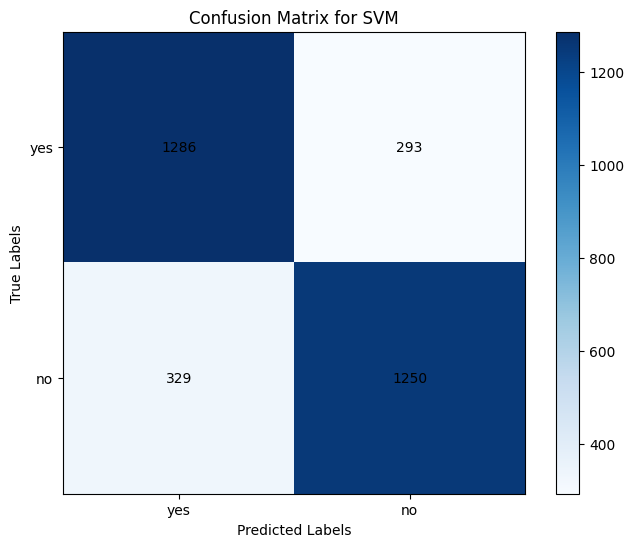

In [23]:
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix_svm, cmap="Blues", interpolation="nearest")
plt.colorbar()
plt.title("Confusion Matrix for SVM")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")

for (i, j), value in np.ndenumerate(conf_matrix_svm):
    plt.text(j, i, f"{value}", ha="center", va="center", color="black")

plt.xticks(range(len(set(y_test))), set(y_test))
plt.yticks(range(len(set(y_test))), set(y_test))
plt.show()

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_35244\1208794986.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=accuracy_data, x="Dataset", y="Accuracy", palette="viridis")


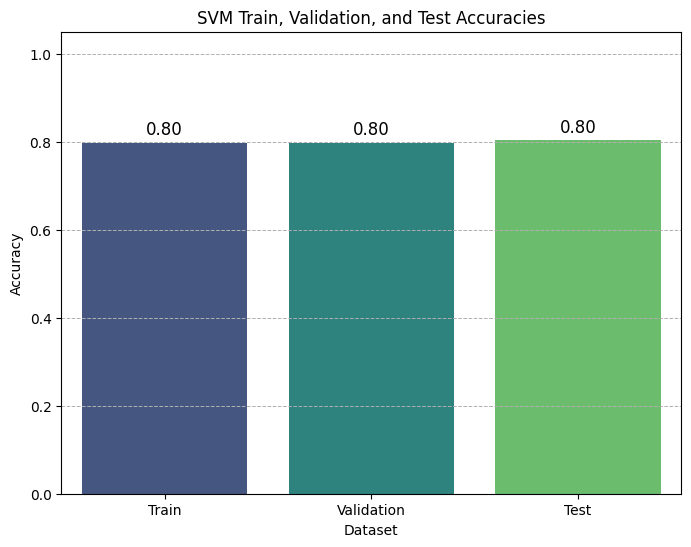

In [24]:
import pandas as pd
import seaborn as sns

accuracy_data = pd.DataFrame({
    "Dataset": ["Train", "Validation", "Test"],
    "Accuracy": [svm_train_accuracy, svm_val_accuracy, svm_test_accuracy]
})

plt.figure(figsize=(8, 6))
ax = sns.barplot(data=accuracy_data, x="Dataset", y="Accuracy", palette="viridis")

for index, row in accuracy_data.iterrows():
    ax.text(index, row['Accuracy'] + 0.01, f"{row['Accuracy']:.2f}", ha='center', va='bottom', fontsize=12)

plt.title("SVM Train, Validation, and Test Accuracies")
plt.ylim(0, 1.05)
plt.ylabel("Accuracy")
plt.xlabel("Dataset")
plt.grid(axis='y', linestyle='--', linewidth=0.7)
plt.show()

# Visualize the Receiver Operating Characteristic (ROC) curve to assess the SVM model's ability to distinguish between classes.

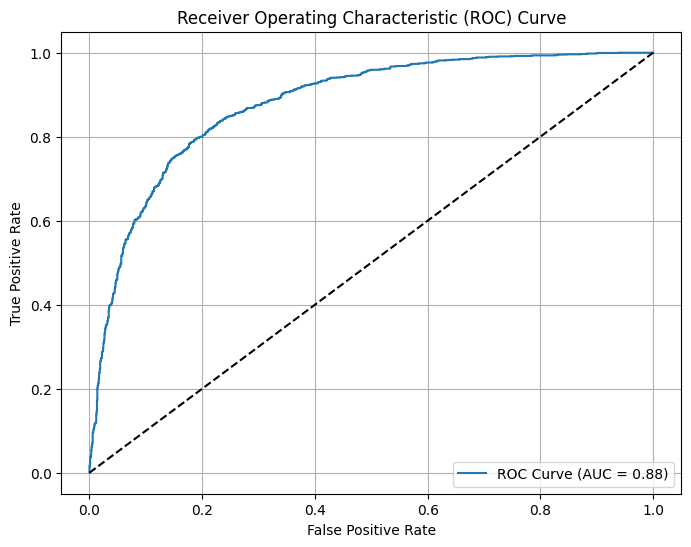

In [25]:
y_test_prob_svm = svm_model.decision_function(X_test_scaled)
fpr, tpr, roc_thresholds = roc_curve(y_test, y_test_prob_svm, pos_label="yes")
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.grid()
plt.show()

# Visualize the Precision-Recall (PR) Curve for the SVM model, which is useful for understanding its performance, particularly in imbalanced datasets.

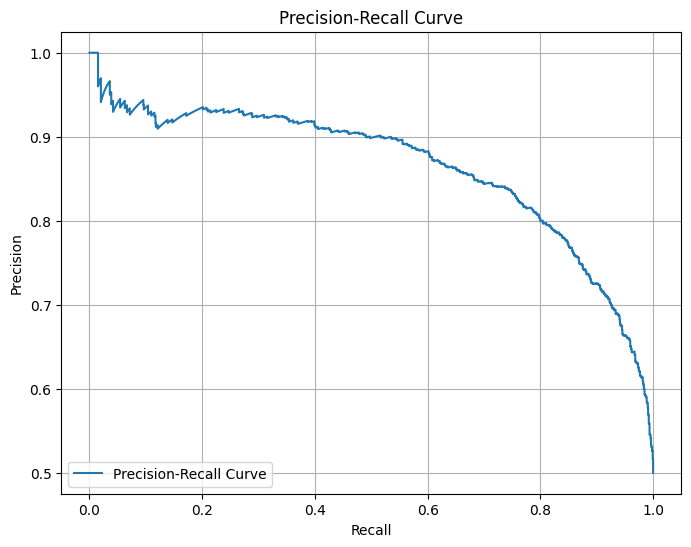

In [26]:
precision, recall, pr_thresholds = precision_recall_curve(y_test, y_test_prob_svm, pos_label="yes")
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label="Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend(loc="lower left")
plt.grid()
plt.show()

# MLP

# Train a Multilayer Perceptron (MLP) classifier for the scream detection classification task.

In [27]:
from sklearn.neural_network import MLPClassifier

print("Training MLP...")
mlp_model = MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=300, random_state=42)
mlp_model.fit(X_train_scaled, y_train)

Training MLP...


MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=300, random_state=42)

# Save the trained MLP model for future use

In [28]:
model_filename_mlp = "mlp_model.joblib"
joblib.dump(mlp_model, model_filename_mlp)
print(f"MLP model saved as {model_filename_mlp}")

MLP model saved as mlp_model.joblib


# Evaluate the trained MLP model on the validation dataset to measure its performance.

In [29]:
y_train_pred_mlp = mlp_model.predict(X_train_scaled)
y_val_pred_mlp = mlp_model.predict(X_val_scaled)

mlp_train_accuracy = accuracy_score(y_train, y_train_pred_mlp)
mlp_val_accuracy = accuracy_score(y_val, y_val_pred_mlp)

print(f"MLP Training Accuracy: {mlp_train_accuracy:.2f}")
print(f"MLP Validation Accuracy: {mlp_val_accuracy:.2f}")

MLP Training Accuracy: 1.00
MLP Validation Accuracy: 0.97


# Evaluate the trained MLP model on the test dataset and calculates a range of performance metrics to provide a comprehensive evaluation.

In [30]:
y_test_pred_mlp = mlp_model.predict(X_test_scaled)

mlp_test_accuracy = accuracy_score(y_test, y_test_pred_mlp)
mlp_precision = precision_score(y_test, y_test_pred_mlp, pos_label="yes")
mlp_recall = recall_score(y_test, y_test_pred_mlp, pos_label="yes")
mlp_f1 = f1_score(y_test, y_test_pred_mlp, pos_label="yes")

print(f"MLP Test Accuracy: {mlp_test_accuracy:.2f}")
print(f"Precision: {mlp_precision:.2f}")
print(f"Recall: {mlp_recall:.2f}")
print(f"F1 Score: {mlp_f1:.2f}")

MLP Test Accuracy: 0.98
Precision: 0.96
Recall: 0.99
F1 Score: 0.98


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_35244\662079767.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=accuracy_data, x="Dataset", y="Accuracy", palette="viridis")


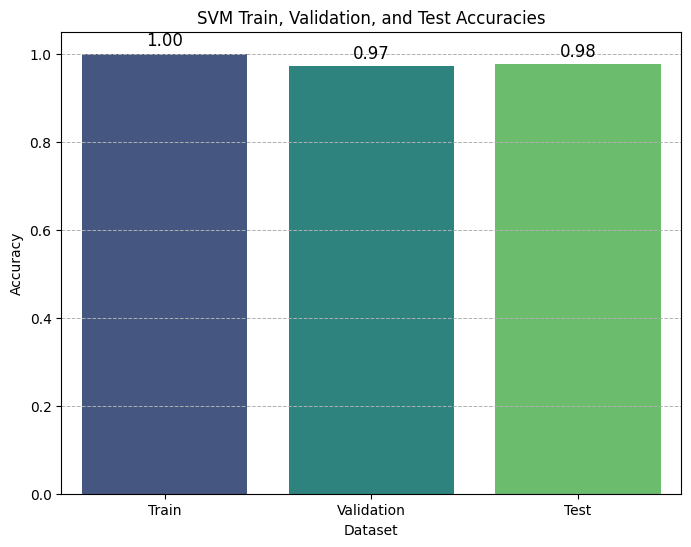

In [31]:
import pandas as pd
import seaborn as sns

accuracy_data = pd.DataFrame({
    "Dataset": ["Train", "Validation", "Test"],
    "Accuracy": [mlp_train_accuracy, mlp_val_accuracy, mlp_test_accuracy]
})

plt.figure(figsize=(8, 6))
ax = sns.barplot(data=accuracy_data, x="Dataset", y="Accuracy", palette="viridis")

for index, row in accuracy_data.iterrows():
    ax.text(index, row['Accuracy'] + 0.01, f"{row['Accuracy']:.2f}", ha='center', va='bottom', fontsize=12)

plt.title("SVM Train, Validation, and Test Accuracies")
plt.ylim(0, 1.05)
plt.ylabel("Accuracy")
plt.xlabel("Dataset")
plt.grid(axis='y', linestyle='--', linewidth=0.7)
plt.show()

In [32]:
print("Classification Report:")
print(classification_report(y_test, y_test_pred_mlp))

Classification Report:
              precision    recall  f1-score   support

          no       0.99      0.96      0.98      1579
         yes       0.96      0.99      0.98      1579

    accuracy                           0.98      3158
   macro avg       0.98      0.98      0.98      3158
weighted avg       0.98      0.98      0.98      3158



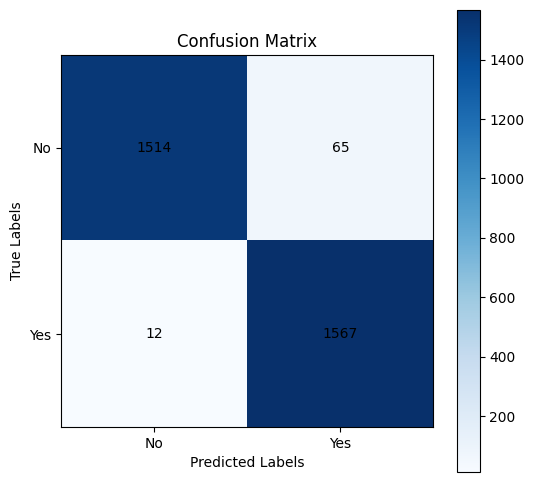

In [33]:
conf_matrix_mlp = confusion_matrix(y_test, y_test_pred_mlp)
plt.figure(figsize=(6, 6))
plt.title("Confusion Matrix")
plt.imshow(conf_matrix_mlp, cmap="Blues", interpolation="nearest")
plt.colorbar()
plt.xticks([0, 1], labels=['No', 'Yes'])
plt.yticks([0, 1], labels=['No', 'Yes'])
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")

for i in range(conf_matrix_mlp.shape[0]):
    for j in range(conf_matrix_mlp.shape[1]):
        plt.text(j, i, conf_matrix_mlp[i, j], ha="center", va="center", color="black")

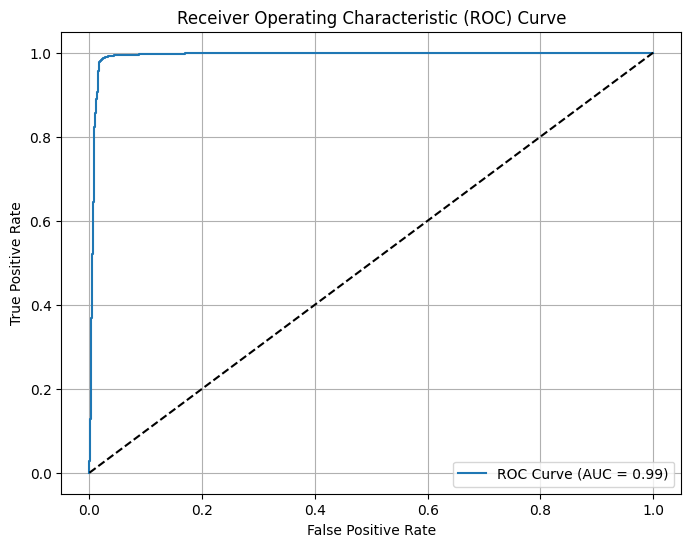

In [34]:
y_test_prob_mlp = mlp_model.predict_proba(X_test_scaled)[:, 1]
fpr, tpr, roc_thresholds = roc_curve(y_test, y_test_prob_mlp, pos_label="yes")
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.grid()
plt.show()

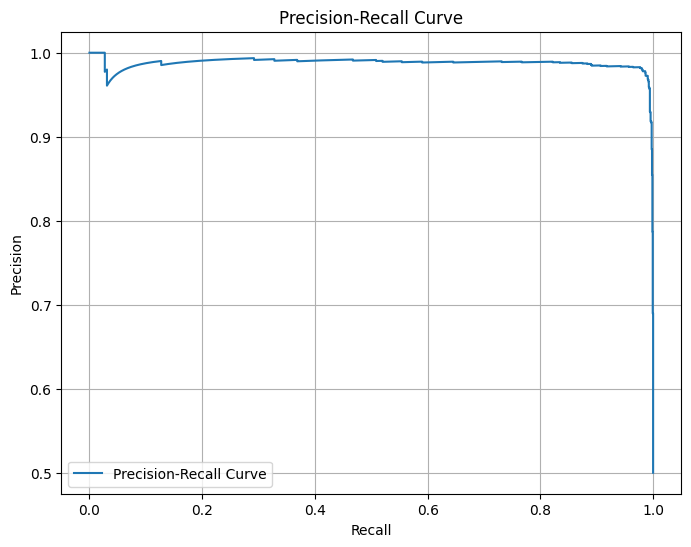

In [35]:
precision, recall, pr_thresholds = precision_recall_curve(y_test, y_test_prob_mlp, pos_label="yes")
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label="Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend(loc="lower left")
plt.grid()
plt.show()

# RESNET

# Generate and saves mel-spectrogram images for the audio dataset to be used as input for RESNET

In [36]:
import os
import librosa
import librosa.display
import matplotlib.pyplot as plt
from tqdm import tqdm

# Directory to save spectrogram images
image_dir = r"D:\Ashraf\NCI\Semester 3\Code\balanced_spectrogram_images"
os.makedirs(image_dir, exist_ok=True)

# Create subdirectories for classes
os.makedirs(os.path.join(image_dir, "yes"), exist_ok=True)
os.makedirs(os.path.join(image_dir, "no"), exist_ok=True)

def save_mel_spectrogram_images(file_paths, labels, image_dir):
    processed_yes = 0
    processed_no = 0
    error_files = []

    for file_path, label in tqdm(zip(file_paths, labels), total=len(file_paths), desc="Generating Spectrograms"):
        try:
            label_dir = os.path.join(image_dir, label)
            os.makedirs(label_dir, exist_ok=True)
            save_path = os.path.join(label_dir, os.path.basename(file_path).replace('.wav', '.png'))
            
            if os.path.exists(save_path) and os.path.getsize(save_path) > 0:
                continue

            audio, sample_rate = librosa.load(file_path, sr=44100)
            
            mel_spectrogram = librosa.feature.melspectrogram(y=audio, sr=sample_rate, n_mels=128, fmax=8000)
            mel_db = librosa.power_to_db(mel_spectrogram, ref=np.max)
            
            plt.figure(figsize=(4, 4))
            librosa.display.specshow(mel_db, sr=sample_rate, x_axis='time', y_axis='mel', cmap='viridis')
            plt.axis('off')
            plt.savefig(save_path, bbox_inches='tight', pad_inches=0)
            plt.close()

            if label == "yes":
                processed_yes += 1
            elif label == "no":
                processed_no += 1

        except Exception as e:
            print(f"Error processing file {file_path}: {e}")
            error_files.append(file_path)

    return processed_yes, processed_no, error_files

batch_size = 1000
total_processed_yes = 0
total_processed_no = 0
all_error_files = []

for i in range(0, len(file_paths_augmented), batch_size):
    batch_files = file_paths_augmented[i:i+batch_size]
    batch_labels = labels_augmented[i:i+batch_size]
    processed_yes, processed_no, error_files = save_mel_spectrogram_images(batch_files, batch_labels, image_dir)

    total_processed_yes += processed_yes
    total_processed_no += processed_no
    all_error_files.extend(error_files)

    print(f"Batch {i // batch_size + 1}/{(len(file_paths_augmented) + batch_size - 1) // batch_size} completed.")
    print(f"YES spectrograms in this batch: {processed_yes}")
    print(f"NO spectrograms in this batch: {processed_no}")
    print(f"Errors in this batch: {len(error_files)}")

print(f"Total YES spectrograms generated: {total_processed_yes}")
print(f"Total NO spectrograms generated: {total_processed_no}")
print(f"Failed to process {len(all_error_files)} files.")

if all_error_files:
    print("Problematic files:")
    for error_file in all_error_files[:10]:
        print(error_file)


Generating Spectrograms: 100%|██████████| 1000/1000 [00:00<00:00, 3893.12it/s]


Batch 1/22 completed.
YES spectrograms in this batch: 0
NO spectrograms in this batch: 0
Errors in this batch: 0


Generating Spectrograms: 100%|██████████| 1000/1000 [00:00<00:00, 4531.07it/s]


Batch 2/22 completed.
YES spectrograms in this batch: 0
NO spectrograms in this batch: 0
Errors in this batch: 0


Generating Spectrograms: 100%|██████████| 1000/1000 [00:00<00:00, 4642.14it/s]


Batch 3/22 completed.
YES spectrograms in this batch: 0
NO spectrograms in this batch: 0
Errors in this batch: 0


Generating Spectrograms: 100%|██████████| 1000/1000 [00:00<00:00, 3554.46it/s]


Batch 4/22 completed.
YES spectrograms in this batch: 0
NO spectrograms in this batch: 0
Errors in this batch: 0


Generating Spectrograms: 100%|██████████| 1000/1000 [00:00<00:00, 3396.20it/s]


Batch 5/22 completed.
YES spectrograms in this batch: 0
NO spectrograms in this batch: 0
Errors in this batch: 0


Generating Spectrograms: 100%|██████████| 1000/1000 [00:00<00:00, 4973.97it/s]


Batch 6/22 completed.
YES spectrograms in this batch: 0
NO spectrograms in this batch: 0
Errors in this batch: 0


Generating Spectrograms: 100%|██████████| 1000/1000 [00:00<00:00, 5244.07it/s]


Batch 7/22 completed.
YES spectrograms in this batch: 0
NO spectrograms in this batch: 0
Errors in this batch: 0


Generating Spectrograms: 100%|██████████| 1000/1000 [00:00<00:00, 5383.49it/s]


Batch 8/22 completed.
YES spectrograms in this batch: 0
NO spectrograms in this batch: 0
Errors in this batch: 0


Generating Spectrograms: 100%|██████████| 1000/1000 [00:00<00:00, 3546.03it/s]


Batch 9/22 completed.
YES spectrograms in this batch: 0
NO spectrograms in this batch: 0
Errors in this batch: 0


Generating Spectrograms: 100%|██████████| 1000/1000 [00:00<00:00, 5280.19it/s]


Batch 10/22 completed.
YES spectrograms in this batch: 0
NO spectrograms in this batch: 0
Errors in this batch: 0


Generating Spectrograms: 100%|██████████| 1000/1000 [00:00<00:00, 5507.86it/s]


Batch 11/22 completed.
YES spectrograms in this batch: 0
NO spectrograms in this batch: 0
Errors in this batch: 0


Generating Spectrograms: 100%|██████████| 1000/1000 [00:00<00:00, 5711.45it/s]


Batch 12/22 completed.
YES spectrograms in this batch: 0
NO spectrograms in this batch: 0
Errors in this batch: 0


Generating Spectrograms: 100%|██████████| 1000/1000 [00:00<00:00, 5009.61it/s]


Batch 13/22 completed.
YES spectrograms in this batch: 0
NO spectrograms in this batch: 0
Errors in this batch: 0


Generating Spectrograms: 100%|██████████| 1000/1000 [00:00<00:00, 5723.73it/s]


Batch 14/22 completed.
YES spectrograms in this batch: 0
NO spectrograms in this batch: 0
Errors in this batch: 0


Generating Spectrograms: 100%|██████████| 1000/1000 [00:00<00:00, 4625.29it/s]


Batch 15/22 completed.
YES spectrograms in this batch: 0
NO spectrograms in this batch: 0
Errors in this batch: 0


Generating Spectrograms: 100%|██████████| 1000/1000 [00:00<00:00, 3909.84it/s]


Batch 16/22 completed.
YES spectrograms in this batch: 0
NO spectrograms in this batch: 0
Errors in this batch: 0


Generating Spectrograms: 100%|██████████| 1000/1000 [00:00<00:00, 4741.82it/s]


Batch 17/22 completed.
YES spectrograms in this batch: 0
NO spectrograms in this batch: 0
Errors in this batch: 0


Generating Spectrograms: 100%|██████████| 1000/1000 [00:00<00:00, 4490.70it/s]


Batch 18/22 completed.
YES spectrograms in this batch: 0
NO spectrograms in this batch: 0
Errors in this batch: 0


Generating Spectrograms: 100%|██████████| 1000/1000 [00:00<00:00, 5318.77it/s]


Batch 19/22 completed.
YES spectrograms in this batch: 0
NO spectrograms in this batch: 0
Errors in this batch: 0


Generating Spectrograms: 100%|██████████| 1000/1000 [00:00<00:00, 4717.21it/s]


Batch 20/22 completed.
YES spectrograms in this batch: 0
NO spectrograms in this batch: 0
Errors in this batch: 0


Generating Spectrograms: 100%|██████████| 1000/1000 [00:00<00:00, 5624.65it/s]


Batch 21/22 completed.
YES spectrograms in this batch: 0
NO spectrograms in this batch: 0
Errors in this batch: 0


Generating Spectrograms: 100%|██████████| 48/48 [00:00<00:00, 4335.48it/s]

Batch 22/22 completed.
YES spectrograms in this batch: 0
NO spectrograms in this batch: 0
Errors in this batch: 0
Total YES spectrograms generated: 0
Total NO spectrograms generated: 0
Failed to process 0 files.


# Load the spectogram images and transform with respect to RESNET. Split the loaded and transformed dataset into train, validation and test data

In [37]:
from torchvision import datasets, transforms, models
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

image_dir = r"D:\Ashraf\NCI\Semester 3\Code\balanced_spectrogram_images"

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

dataset = datasets.ImageFolder(root=image_dir, transform=transform)

train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Train a RESNET model and save the best model

In [38]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet_model = models.resnet34(pretrained=True)

resnet_model.fc = nn.Linear(resnet_model.fc.in_features, 2)
resnet_model = resnet_model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet_model.parameters(), lr=0.001)

epochs = 10
best_val_accuracy = 0.0

for epoch in range(epochs):
    resnet_model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = resnet_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    
    train_accuracy = correct / total
    
    resnet_model.eval()
    val_correct = 0
    val_total = 0
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = resnet_model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)
    
    val_accuracy = val_correct / val_total
    
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        torch.save(resnet_model.state_dict(), "resnet34_best.pth")
    
    print(f"Epoch {epoch+1}/{epochs} - Train Loss: {running_loss/len(train_loader):.4f}, "
          f"Train Accuracy: {train_accuracy*100:.2f}% | Val Loss: {val_loss/len(val_loader):.4f}, "
          f"Val Accuracy: {val_accuracy*100:.2f}%")

print("Training complete. Best validation accuracy:", best_val_accuracy)

c:\Users\Lenovo\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Lenovo\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/10 - Train Loss: 0.3131, Train Accuracy: 87.39% | Val Loss: 0.3516, Val Accuracy: 88.06%
Epoch 2/10 - Train Loss: 0.2352, Train Accuracy: 90.05% | Val Loss: 0.2331, Val Accuracy: 91.99%
Epoch 3/10 - Train Loss: 0.1939, Train Accuracy: 92.13% | Val Loss: 0.2828, Val Accuracy: 88.65%
Epoch 4/10 - Train Loss: 0.1580, Train Accuracy: 93.79% | Val Loss: 0.2836, Val Accuracy: 91.12%
Epoch 5/10 - Train Loss: 0.1353, Train Accuracy: 94.67% | Val Loss: 0.1687, Val Accuracy: 94.18%
Epoch 6/10 - Train Loss: 0.1032, Train Accuracy: 96.02% | Val Loss: 0.2014, Val Accuracy: 92.79%
Epoch 7/10 - Train Loss: 0.0826, Train Accuracy: 96.83% | Val Loss: 0.2097, Val Accuracy: 92.79%
Epoch 8/10 - Train Loss: 0.0734, Train Accuracy: 97.29% | Val Loss: 0.1246, Val Accuracy: 95.56%
Epoch 9/10 - Train Loss: 0.0559, Train Accuracy: 97.92% | Val Loss: 0.1602, Val Accuracy: 94.03%
Epoch 10/10 - Train Loss: 0.0512, Train Accuracy: 98.11% | Val Loss: 0.2016, Val Accuracy: 93.67%
Training complete. Best valid

In [39]:
# y_true = []
# y_pred = []

# with torch.no_grad():
#     for images, labels in test_loader:
#         images, labels = images.to(device), labels.to(device)
#         outputs = resnet_model(images)
#         _, preds = torch.max(outputs, 1)
#         y_true.extend(labels.cpu().numpy())
#         y_pred.extend(preds.cpu().numpy())

# Validate the model

In [40]:
import torch
from sklearn.metrics import accuracy_score

def evaluate_model(model, data_loader, device):
    true_labels = []
    predicted_labels = []
    predicted_probs = []
    
    resnet_model.eval()
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            
            true_labels.extend(labels.cpu().numpy())
            predicted_labels.extend(preds.cpu().numpy())
            predicted_probs.extend(torch.nn.functional.softmax(outputs, dim=1)[:, 1].cpu().numpy())
    
    accuracy = accuracy_score(true_labels, predicted_labels)
    
    return true_labels, predicted_labels, predicted_probs, accuracy

true_labels_train, predicted_labels_train, predicted_probs_train, train_accuracy = evaluate_model(resnet_model, train_loader, device)
true_labels_val, predicted_labels_val, predicted_probs_val, val_accuracy = evaluate_model(resnet_model, val_loader, device)
true_labels_test, predicted_labels_test, predicted_probs_test, test_accuracy = evaluate_model(resnet_model, test_loader, device)

# Print accuracies
print(f"Training Accuracy: {train_accuracy:.2f}")
print(f"Validation Accuracy: {val_accuracy:.2f}")
print(f"Test Accuracy: {test_accuracy:.2f}")

Training Accuracy: 0.98
Validation Accuracy: 0.94
Test Accuracy: 0.94


In [41]:
# true_labels_val = []
# predicted_labels_val = []
# predicted_probs_val = []

# resnet_model.eval()
# with torch.no_grad():
#     for images, labels in val_loader:
#         images, labels = images.to(device), labels.to(device)
#         outputs = resnet_model(images)
#         _, preds = torch.max(outputs, 1)
#         true_labels_val.extend(labels.cpu().numpy())
#         predicted_labels_val.extend(preds.cpu().numpy())
#         predicted_probs_val.extend(torch.nn.functional.softmax(outputs, dim=1)[:, 1].cpu().numpy())

# Metrics for validation

In [42]:
# val_accuracy = accuracy_score(true_labels_val, predicted_labels_val)
# val_precision = precision_score(true_labels_val, predicted_labels_val, average="weighted")
# val_recall = recall_score(true_labels_val, predicted_labels_val, average="weighted")
# val_f1 = f1_score(true_labels_val, predicted_labels_val, average="weighted")

# print(f"Validation Accuracy: {val_accuracy:.2f}")
# print(f"Validation Precision: {val_precision:.2f}")
# print(f"Validation Recall: {val_recall:.2f}")
# print(f"Validation F1 Score: {val_f1:.2f}")

# Test the model

In [43]:
# true_labels_test = []
# predicted_labels_test = []
# predicted_probs_test = []

# with torch.no_grad():
#     for images, labels in test_loader:
#         images, labels = images.to(device), labels.to(device)
#         outputs = resnet_model(images)
#         _, preds = torch.max(outputs, 1)
#         true_labels_test.extend(labels.cpu().numpy())
#         predicted_labels_test.extend(preds.cpu().numpy())
#         predicted_probs_test.extend(torch.nn.functional.softmax(outputs, dim=1)[:, 1].cpu().numpy())

# Metrics for evaluating test performance

In [44]:
test_accuracy = accuracy_score(true_labels_test, predicted_labels_test)
test_precision = precision_score(true_labels_test, predicted_labels_test, average="weighted")
test_recall = recall_score(true_labels_test, predicted_labels_test, average="weighted")
test_f1 = f1_score(true_labels_test, predicted_labels_test, average="weighted")

print(f"Test Accuracy: {test_accuracy:.2f}")
print(f"Test Precision: {test_precision:.2f}")
print(f"Test Recall: {test_recall:.2f}")
print(f"Test F1 Score: {test_f1:.2f}")

Test Accuracy: 0.94
Test Precision: 0.94
Test Recall: 0.94
Test F1 Score: 0.94


In [45]:
print("Test Classification Report:")
print(classification_report(true_labels_test, predicted_labels_test, target_names=dataset.classes))

print("\nTest Confusion Matrix:")
print(confusion_matrix(true_labels_test, predicted_labels_test))

Test Classification Report:
              precision    recall  f1-score   support

          no       0.97      0.95      0.96      1044
         yes       0.85      0.91      0.88       331

    accuracy                           0.94      1375
   macro avg       0.91      0.93      0.92      1375
weighted avg       0.94      0.94      0.94      1375


Test Confusion Matrix:
[[991  53]
 [ 30 301]]


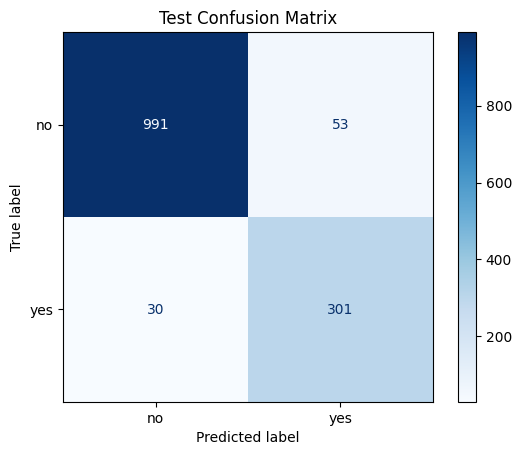

In [46]:
from sklearn.metrics import ConfusionMatrixDisplay

conf_matrix_test = confusion_matrix(true_labels_test, predicted_labels_test)
disp_test = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_test, display_labels=dataset.classes)
disp_test.plot(cmap="Blues")
plt.title("Test Confusion Matrix")
plt.show()

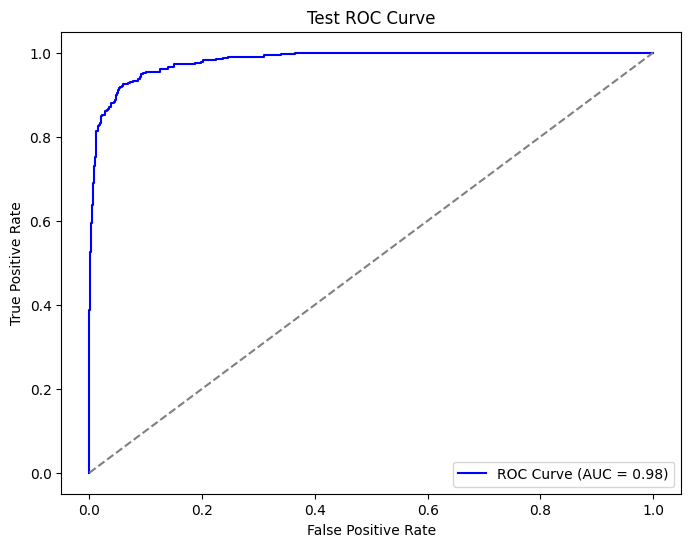

In [47]:
from sklearn.metrics import roc_auc_score

fpr_test, tpr_test, _ = roc_curve(true_labels_test, predicted_probs_test)
roc_auc_test = roc_auc_score(true_labels_test, predicted_probs_test)
precision_test, recall_test, _ = precision_recall_curve(true_labels_test, predicted_probs_test)

plt.figure(figsize=(8, 6))

plt.plot(fpr_test, tpr_test, color='blue', label=f'ROC Curve (AUC = {roc_auc_test:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Test ROC Curve')
plt.legend()

plt.show()

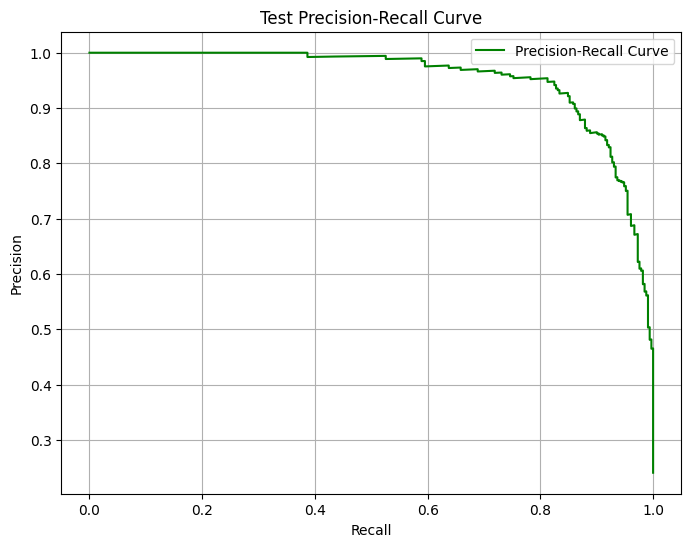

In [48]:
plt.figure(figsize=(8, 6))

plt.plot(recall_test, precision_test, color='green', label='Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Test Precision-Recall Curve')
plt.legend()

plt.grid()
plt.show()